In [1]:
import tensorflow as tf

2023-08-21 20:47:00.597404: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-21 20:47:00.625725: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-21 20:47:01.169602: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tf.__version__

'2.13.0'

In [3]:
import glob
# import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
# from tensorflow.python.keras import layers
from tensorflow.keras import layers, activations
import time
import nibabel as nib
from tqdm import tqdm
import gc
from scipy.ndimage import binary_erosion
from IPython import display
import datetime

import model

In [4]:
subjects = [ f.name for f in os.scandir('./Data') if f.is_dir() and f.name != '.ipynb_checkpoints']

# subjects = ['390645', '120111']

e_or_o = 0

p_size_i = 16
p_size_o = p_size_i

print(subjects)

['390645', '545345', '106016', '120111', '101915', '351938', '705341']


In [5]:
subjects_lr = []
subjects_hr = []
subjects_masks = []

subjects_preproc_values_lr = []
subjects_preproc_values_hr = []

subjects_preproc_values_h4_lr = []
subjects_preproc_values_h4_hr = []

subjects_t1_preproc_values = []

for subj in subjects:

    h4_imgs = []
    h4_imgs_lr = []
    dti_imgs = []
    dti_imgs_lr = []

    # DTI normalisation metrics pre-normalisation (storing max and min values in the mask) - Store for HR only
    dti_preprocs_hr = np.zeros((6,2))
    dti_preprocs_lr = np.zeros((6,2))

    h4_preprocs_hr = np.zeros((22,2))
    h4_preprocs_lr = np.zeros((22,2))

    print("Loading Subject {}".format(subj))
    
    for i in range(1,9):
    
        dti_data = np.array(nib.load("Data/{}/T1w/Diffusion/dt_all_{}.nii".format(subj,i)).get_fdata())
        dti_data_lr = np.array(nib.load("Data/{}/T1w/Diffusion/dt_all_lowres_2_{}.nii".format(subj,i)).get_fdata())
    
        # if i > 1:
        #     dti_data[dti_imgs[0] < 0] = 0
        #     dti_data_lr[dti_imgs[0] < 0] = 0
    
        dti_imgs.append(dti_data)
        dti_imgs_lr.append(dti_data_lr)
    
        dti_data = None
        dti_data_lr = None
    
    for i in range(1,25):
    
        h4_data = np.array(nib.load("Data/{}/T1w/Diffusion/h4_all_{}.nii".format(subj,str(i).zfill(2))).get_fdata())
        h4_data_lr = np.array(nib.load("Data/{}/T1w/Diffusion/h4_all_lowres_2_{}.nii".format(subj,str(i).zfill(2))).get_fdata())
    
        # if i > 1:
        #     h4_data[h4_data[0] < 0] = 0
        #     h4_data_lr[h4_data[0] < 0] = 0
        
        h4_imgs.append(h4_data)
        h4_imgs_lr.append(h4_data_lr)
    
        h4_data = None
        h4_data_lr = None
    
    h4_imgs = np.array(h4_imgs).transpose((1,2,3,0))
    h4_imgs_lr = np.array(h4_imgs_lr).transpose((1,2,3,0))
    
    dti_imgs = np.array(dti_imgs).transpose((1,2,3,0))
    dti_imgs_lr = np.array(dti_imgs_lr).transpose((1,2,3,0))
    
    mask = h4_imgs[...,0]

    binmask = np.zeros(mask.shape)

    binmask[mask >= 0] = 1

    mask = binary_erosion(binmask, structure=np.ones((5,5,5),np.uint8),iterations = 1)

    binmask = None

    # Calculate DTI ranges and normalise to range [0,1]
    for i in range(2,8):

        dti_preprocs_lr[i-2,:] = np.array([np.min(mask*dti_imgs_lr[...,i]), np.max(mask*dti_imgs_lr[...,i])])
        dti_imgs_lr[mask>0, i] = (dti_imgs_lr[mask>0, i] - dti_preprocs_lr[i-2,0] + 0.0001) / (dti_preprocs_lr[i-2,1] - dti_preprocs_lr[i-2,0])
        dti_imgs_lr[mask==0, i] = 0

        dti_preprocs_hr[i-2,:] = np.array([np.min(mask*dti_imgs[...,i]), np.max(mask*dti_imgs[...,i])])
        dti_imgs[mask>0, i] = (dti_imgs[mask>0, i] - dti_preprocs_hr[i-2,0] + 0.0001) / (dti_preprocs_hr[i-2,1] - dti_preprocs_hr[i-2,0])
        dti_imgs[mask==0, i] = 0


    # Calculate H4 ranges and normalise to range [0,1]
    for i in range(2,24):

        h4_preprocs_lr[i-2,:] = np.array([np.min(mask*h4_imgs_lr[...,i]), np.max(mask*h4_imgs_lr[...,i])])
        h4_imgs_lr[mask>0, i] = (h4_imgs_lr[mask>0, i] - h4_preprocs_lr[i-2,0] + 0.0001) / (h4_preprocs_lr[i-2,1] - h4_preprocs_lr[i-2,0])
        h4_imgs_lr[mask==0, i] = 0

        h4_preprocs_hr[i-2,:] = np.array([np.min(mask*h4_imgs[...,i]), np.max(mask*h4_imgs[...,i])])
        h4_imgs[mask>0, i] = (h4_imgs[mask>0, i] - h4_preprocs_hr[i-2,0] + 0.0001) / (h4_preprocs_hr[i-2,1] - h4_preprocs_hr[i-2,0])
        h4_imgs[mask==0, i] = 0


    t1w = nib.load("Data/{}/T1w/Diffusion/t1w.nii".format(subj))
    
    t1w_data = np.array(t1w.get_fdata())
    
    t1w_data_format = np.concatenate(
        (t1w_data[::2,::2,::2, None], t1w_data[::2,::2,1::2, None],
         t1w_data[::2,1::2,::2, None], t1w_data[::2,1::2,1::2, None],
         t1w_data[1::2,::2,::2, None], t1w_data[1::2,::2,1::2, None],
         t1w_data[1::2,1::2,::2, None], t1w_data[1::2,1::2,1::2, None]),
        axis=-1)

    t1w_preprocs = np.array([np.min(t1w_data_format*mask[...,None]), np.max(t1w_data_format*mask[...,None])])
    
    subjects_t1_preproc_values.append(t1w_preprocs)    
    t1w_data_format[mask>0, :] = (t1w_data_format[mask>0, :] - t1w_preprocs[0] + 0.0001) / (t1w_preprocs[1] - t1w_preprocs[0])

    subjects_preproc_values_lr.append(dti_preprocs_lr)
    subjects_preproc_values_hr.append(dti_preprocs_hr)

    subjects_preproc_values_h4_lr.append(h4_preprocs_lr)
    subjects_preproc_values_h4_hr.append(h4_preprocs_hr)

    lowres_input = np.concatenate((h4_imgs_lr[...,2:], dti_imgs_lr[...,2:], t1w_data_format), axis=-1)
    hires_output = np.copy(h4_imgs[...,2:])
    
    # lowres_input = np.concatenate((h4_imgs_lr[...,2:], dti_imgs_lr[...,2:], t1w_data_format), axis=-1)
    # hires_output = np.copy(h4_imgs[...,2:])

    subjects_lr.append(lowres_input)
    subjects_hr.append(hires_output)
    subjects_masks.append(mask)


Loading Subject 390645
Loading Subject 545345
Loading Subject 106016
Loading Subject 120111
Loading Subject 101915
Loading Subject 351938
Loading Subject 705341


In [6]:
input_layer = tf.keras.Input(shape=(2*p_size_i, 2*p_size_i, 2*p_size_i, 36))
output_layer = model.unet3d(input_layer, 50, 22)

output_layer = tf.keras.activations.sigmoid(output_layer)

generator = tf.keras.Model(input_layer, output_layer)
# generator = tf.keras.activations.sigmoid(generator)

discriminator = model.simple_discriminator(6,2*p_size_o+e_or_o)

2023-08-21 20:47:18.606615: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-21 20:47:18.620340: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-21 20:47:18.620460: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

(None, 1)


In [7]:
print(generator.summary())
print(discriminator.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 32, 14)]     0         []                            
                                                                                                  
 conv3d (Conv3D)             (None, 32, 32, 32, 50)       18950     ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 32, 50)       200       ['conv3d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv3d_1 (Conv3D)           (None, 32, 32, 32, 50)       67550     ['batch_normalization[0][0

In [8]:
# cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

cross_entropy_gen = tf.keras.losses.BinaryCrossentropy()
cross_entropy_disc = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):

    # real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_output, labels=tf.ones_like(real_output)))
    # fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_output, labels=tf.zeros_like(fake_output)))

    # total_loss = real_loss + fake_loss
                               
    # return total_loss
    
    real_loss = tf.reduce_mean(cross_entropy_gen(tf.ones_like(real_output), real_output))
    fake_loss = tf.reduce_mean(cross_entropy_gen(tf.zeros_like(fake_output), fake_output))
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):

    # gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_output, labels=tf.ones_like(fake_output)))

    # return gen_loss

    return tf.reduce_mean(cross_entropy_gen(tf.ones_like(fake_output), fake_output))

In [9]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=50*100,
    decay_rate=0.1
)

generator_optimizer = tf.keras.optimizers.Adam(lr_schedule)
discriminator_optimizer = tf.keras.optimizers.Adam(lr_schedule)

In [10]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

gen_loss_metric = tf.keras.metrics.Mean('gen_loss', dtype=tf.float32)
# gen_accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy('gen_accuracy')

disc_loss_metric = tf.keras.metrics.Mean('disc_loss', dtype=tf.float32)

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = './logs/unet_gan/' + current_time + '/train'
summary_writer = tf.summary.create_file_writer(log_dir)

In [11]:
@tf.function
def train_step(lr_patch, hr_patch):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(lr_patch, training=True)

      real_output = discriminator(hr_patch, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gen_loss_metric(gen_loss)
    # gen_accuracy_metric(hr_patch, generated_images)

    disc_loss_metric(disc_loss)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

@tf.function
def train_step_gen(lr_patch, hr_patch):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        generated_images = generator(lr_patch, training=True)

        real_output = discriminator(hr_patch, training=False)
        fake_output = discriminator(generated_images, training=False)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    return gen_loss, disc_loss

@tf.function
def train_step_disc(lr_patch, hr_patch):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        generated_images = generator(lr_patch, training=False)

        real_output = discriminator(hr_patch, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [12]:
def train(data, epochs):

  gen_train_mode = False
    
  for epoch in range(epochs):

    if epoch > 0 and epoch % 2 == 0:
        gen_train_mode = not gen_train_mode
      
    start = time.time()

    print("Epoch: {}".format(epoch+1))

    print("Learning rate:", generator_optimizer.learning_rate.numpy())


    mean_g_loss = 0.0
    mean_d_loss = 0.0
    total_cost = 0.0

    # [sel_indices, subjects_lr, subjects_hr, subjects_masks]

    randsels = np.random.choice(data[0].shape[0],data[0].shape[0]//4)

    lr_patches = []
    hr_patches = []

    for prog, index in enumerate(tqdm(randsels)):

        if (prog+1) % 8 != 0 or prog == (len(randsels) - 1):

            (s, i, j, k) = data[0][index]
        
            lr_patch = np.copy(data[1][s][
                                    i - p_size_i - e_or_o : i + p_size_i,
                                    j - p_size_i - e_or_o : j + p_size_i,
                                    k - p_size_i - e_or_o : k + p_size_i, :]) * \
            np.copy(data[3][s][
                                    i - p_size_i - e_or_o : i + p_size_i,
                                    j - p_size_i - e_or_o : j + p_size_i,
                                    k - p_size_i - e_or_o : k + p_size_i, None])
                               
        
            hr_patch = np.copy(data[2][s][
                                    i - p_size_o - e_or_o : i + p_size_o,
                                    j - p_size_o - e_or_o : j + p_size_o,
                                    k - p_size_o - e_or_o : k + p_size_o, :]) * \
            np.copy(data[3][s][
                                    i - p_size_o - e_or_o : i + p_size_o,
                                    j - p_size_o - e_or_o : j + p_size_o,
                                    k - p_size_o - e_or_o : k + p_size_o, None])

            lr_patches.append(lr_patch)
            hr_patches.append(hr_patch)
            
            continue
        
        lr_patches = tf.convert_to_tensor(np.array(lr_patches), dtype=tf.float32)
        hr_patches = tf.convert_to_tensor(np.array(hr_patches), dtype=tf.float32)

        g_loss, d_loss = train_step(lr_patches, hr_patches)

        with summary_writer.as_default():
            tf.summary.scalar('gen_loss', gen_loss_metric.result(), step=epoch)
            tf.summary.scalar('disc_loss', disc_loss_metric.result(), step=epoch)
        
        # if gen_train_mode:
        #     g_loss, d_loss = train_step_gen(lr_patch, hr_patch)
        # else:
        #     g_loss, d_loss = train_step_disc(lr_patch, hr_patch)
        
        mean_g_loss = mean_g_loss + g_loss
        mean_d_loss = mean_d_loss + d_loss

        y_preds = generator(lr_patches, training=False)

        total_cost = total_cost + tf.reduce_mean(tf.square(hr_patches - y_preds))

        lr_patches = []
        hr_patches = []
      
    # Save the model every 5 epochs
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    # print('Generator Loss is {}'.format(float(mean_g_loss/len(randsels))))
    # print('Discriminator Loss is {}'.format(float(mean_d_loss/len(randsels))))

    print('Generator Error Metric is {}'.format(float(total_cost/(len(randsels)//4))))
      
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

In [13]:
(xsize, ysize, zsize, comp) = subjects_lr[0].shape

split_indices = [(i, j, k)
                 for k in np.arange(p_size_i+1,zsize-p_size_i+e_or_o,2*p_size_o+e_or_o)       
                 for j in np.arange(p_size_i+1,ysize-p_size_i+e_or_o,2*p_size_o+e_or_o)
                 for i in np.arange(p_size_i+1,xsize-p_size_i+e_or_o,2*p_size_o+e_or_o)
                ]

sel_indices = []

for s in range(len(subjects_lr)):
    for (i, j, k) in split_indices:
        ipatch_mask = subjects_masks[s][
            i - p_size_o - e_or_o : i + p_size_o,
            j - p_size_o - e_or_o : j + p_size_o,
            k - p_size_o - e_or_o : k + p_size_o]
    
        if np.max(ipatch_mask) > 0:
            sel_indices.append((s,i,j,k))

sel_indices = np.array(sel_indices)

In [14]:
# for s in range(7):

#     print("Subject {}".format(s+1))

#     lr_patches = []
#     hr_patches = []

#     for (i, j, k) in sel_indices[np.where(sel_indices[:,0]==s),1:].squeeze():
    
    
#         lr_patch = np.copy(subjects_lr[s][
#                                 i - p_size_i - 1 : i + p_size_i,, vmax=2.0
#                                 j - p_size_i - 1 : j + p_size_i,
#                                 k - p_size_i - 1 : k + p_size_i, :])
                           
    
#         hr_patch = np.copy(subjects_hr[s][
#                                 i - p_size_o - e_or_o : i + p_size_o,
#                                 j - p_size_o - e_or_o : j + p_size_o,
#                                 k - p_size_o - e_or_o : k + p_size_o, :])
                           
#         ipatch_mask = subjects_masks[s][
#                                 i - p_size_i - e_or_o : i + p_size_i,
#                                 j - p_size_i - e_or_o : j + p_size_i,
#                                 k - p_size_i - e_or_o : k + p_size_i]

#         opatch_mask = subjects_masks[s][
#                                 i - p_size_o - e_or_o : i + p_size_o,
#                                 j - p_size_o - e_or_o : j + p_size_o,
#                                 k - p_size_o - e_or_o : k + p_size_o]

#         lr_patch[ipatch_mask == 0] = 0
#         hr_patch[opatch_mask == 0] = 0

#         lr_patches.append(lr_patch)
#         hr_patches.append(hr_patch)

#     lr_patches = np.array(lr_patches)
#     hr_patches = np.array(hr_patches)

#     # lr_patches = np.array([subjects_lr[s][
#     #                             i - p_size_i - 1 : i + p_size_i,
#     #                             j - p_size_i - 1 : j + p_size_i,
#     #                             k - p_size_i - 1 : k + p_size_i, :]
#     #                        for (i,j,k) in sel_indices[np.where(sel_indices[:,0]==s),1:].squeeze()])
    
#     # hr_patches = np.array([subjects_hr[s][
#     #                             i - p_size_o - e_or_o : i + p_size_o,
#     #                             j - p_size_o - e_or_o : j + p_size_o,
#     #                             k - p_size_o - e_or_o : k + p_size_o, :]
#     #                        for (i,j,k) in sel_indices[np.where(sel_indices[:,0]==s),1:].squeeze()])
    
# # lr_patches = np.array([subjects_lr[s][
# #                             i - p_size_i - e_or_o : i + p_size_i,
# #                             j - p_size_i - e_or_o : j + p_size_i,
# #                             k - p_size_i - e_or_o : k + p_size_i, :]
# #                        # for (i,j,k) in sel_indices[np.where(sel_indices[:,0]==s),1:].squeeze()])
# #                        for (s,i,j,k) in sel_indices])

# # hr_patches = np.array([subjects_hr[s][
# #                             i - p_size_o - e_or_o : i + p_size_o,
# #                             j - p_size_o - e_or_o : j + p_size_o,
# #                             k - p_size_o - e_or_o : k + p_size_o, :]
# #                        # for (i,j,k) in sel_indices[np.where(sel_indices[:,0]==s),1:].squeeze()])
# #                        for (s,i,j,k) in sel_indices])

#     dataset = tf.data.Dataset.from_tensor_slices((lr_patches, hr_patches))
    
train([sel_indices, subjects_lr, subjects_hr, subjects_masks], 200)

Epoch: 1
Learning rate: 0.001


  0%|                                                   | 0/101 [00:00<?, ?it/s]2023-08-21 20:47:25.079907: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-21 20:47:26.886486: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-21 20:47:28.951469: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fba9ba59a20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-21 20:47:28.951486: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090 Ti, Compute Capability 8.6
2023-08-21 20:47:28.954626: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-21 20:47:29.120527: I ./tensorflow/compiler/jit/device_compiler.h:186] Comp

Generator Error Metric is 0.09417472779750824
Time for epoch 1 is 21.892961263656616 sec
Epoch: 2
Learning rate: 0.0009949472


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 32.33it/s]


Generator Error Metric is 0.3248867392539978
Time for epoch 2 is 3.125828504562378 sec
Epoch: 3
Learning rate: 0.000989464


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 32.16it/s]


Generator Error Metric is 0.31905269622802734
Time for epoch 3 is 3.1421499252319336 sec
Epoch: 4
Learning rate: 0.0009840111


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.17it/s]


Generator Error Metric is 0.28906258940696716
Time for epoch 4 is 3.2422757148742676 sec
Epoch: 5
Learning rate: 0.0009785884


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 32.19it/s]


Generator Error Metric is 0.3040619492530823
Time for epoch 5 is 7.935640096664429 sec
Epoch: 6
Learning rate: 0.00097319536


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 34.52it/s]


Generator Error Metric is 0.2518044710159302
Time for epoch 6 is 2.9340779781341553 sec
Epoch: 7
Learning rate: 0.00096783205


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 35.21it/s]


Generator Error Metric is 0.14799705147743225
Time for epoch 7 is 2.8779423236846924 sec
Epoch: 8
Learning rate: 0.0009624984


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 35.12it/s]


Generator Error Metric is 0.13159336149692535
Time for epoch 8 is 2.883436441421509 sec
Epoch: 9
Learning rate: 0.00095719413


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 35.38it/s]


Generator Error Metric is 0.23890766501426697
Time for epoch 9 is 2.864780902862549 sec
Epoch: 10
Learning rate: 0.00095191906


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 34.26it/s]


Generator Error Metric is 0.28790178894996643
Time for epoch 10 is 7.624110698699951 sec
Epoch: 11
Learning rate: 0.00094667304


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.10it/s]


Generator Error Metric is 0.232774555683136
Time for epoch 11 is 3.2502965927124023 sec
Epoch: 12
Learning rate: 0.000941456


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.46it/s]


Generator Error Metric is 0.1883859783411026
Time for epoch 12 is 3.2124991416931152 sec
Epoch: 13
Learning rate: 0.00093626766


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 32.04it/s]


Generator Error Metric is 0.12525898218154907
Time for epoch 13 is 3.162118434906006 sec
Epoch: 14
Learning rate: 0.0009311079


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 34.27it/s]


Generator Error Metric is 0.0644429475069046
Time for epoch 14 is 2.9577932357788086 sec
Epoch: 15
Learning rate: 0.00092597655


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 34.86it/s]


Generator Error Metric is 0.05206286907196045
Time for epoch 15 is 7.578817844390869 sec
Epoch: 16
Learning rate: 0.00092087354


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 32.17it/s]


Generator Error Metric is 0.13732795417308807
Time for epoch 16 is 3.1413331031799316 sec
Epoch: 17
Learning rate: 0.0009157987


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 32.23it/s]


Generator Error Metric is 0.15046526491641998
Time for epoch 17 is 3.135735511779785 sec
Epoch: 18
Learning rate: 0.0009107518


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 32.17it/s]


Generator Error Metric is 0.15501809120178223
Time for epoch 18 is 3.141335964202881 sec
Epoch: 19
Learning rate: 0.0009057326


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 32.15it/s]


Generator Error Metric is 0.11409227550029755
Time for epoch 19 is 3.143256425857544 sec
Epoch: 20
Learning rate: 0.00090074114


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 32.19it/s]


Generator Error Metric is 0.1433093249797821
Time for epoch 20 is 7.9684226512908936 sec
Epoch: 21
Learning rate: 0.00089577725


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 35.54it/s]


Generator Error Metric is 0.18711112439632416
Time for epoch 21 is 2.8498265743255615 sec
Epoch: 22
Learning rate: 0.0008908407


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 35.68it/s]


Generator Error Metric is 0.0740261822938919
Time for epoch 22 is 2.8389222621917725 sec
Epoch: 23
Learning rate: 0.0008859312


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 34.71it/s]


Generator Error Metric is 0.04680127650499344
Time for epoch 23 is 2.9180643558502197 sec
Epoch: 24
Learning rate: 0.0008810489


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 35.13it/s]


Generator Error Metric is 0.11270636320114136
Time for epoch 24 is 2.8846116065979004 sec
Epoch: 25
Learning rate: 0.0008761935


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 35.03it/s]


Generator Error Metric is 0.12400103360414505
Time for epoch 25 is 7.716525077819824 sec
Epoch: 26
Learning rate: 0.0008713647


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.34it/s]


Generator Error Metric is 0.16121476888656616
Time for epoch 26 is 3.224639892578125 sec
Epoch: 27
Learning rate: 0.00086656277


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.68it/s]


Generator Error Metric is 0.09283176064491272
Time for epoch 27 is 3.1906797885894775 sec
Epoch: 28
Learning rate: 0.0008617871


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.75it/s]


Generator Error Metric is 0.0816086083650589
Time for epoch 28 is 3.182772159576416 sec
Epoch: 29
Learning rate: 0.0008570379


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.91it/s]


Generator Error Metric is 0.08949470520019531
Time for epoch 29 is 3.166706085205078 sec
Epoch: 30
Learning rate: 0.00085231476


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 32.19it/s]


Generator Error Metric is 0.10250262171030045
Time for epoch 30 is 7.983287811279297 sec
Epoch: 31
Learning rate: 0.0008476177


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 35.61it/s]


Generator Error Metric is 0.14874212443828583
Time for epoch 31 is 2.8456456661224365 sec
Epoch: 32
Learning rate: 0.0008429465


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 35.12it/s]


Generator Error Metric is 0.07855254411697388
Time for epoch 32 is 2.885436534881592 sec
Epoch: 33
Learning rate: 0.000838301


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 33.59it/s]


Generator Error Metric is 0.20282535254955292
Time for epoch 33 is 3.0154836177825928 sec
Epoch: 34
Learning rate: 0.0008336812


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 34.93it/s]


Generator Error Metric is 0.23893333971500397
Time for epoch 34 is 2.899888753890991 sec
Epoch: 35
Learning rate: 0.0008290868


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 34.26it/s]


Generator Error Metric is 0.15127095580101013
Time for epoch 35 is 7.744077682495117 sec
Epoch: 36
Learning rate: 0.00082451775


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 30.71it/s]


Generator Error Metric is 0.14196592569351196
Time for epoch 36 is 3.291806697845459 sec
Epoch: 37
Learning rate: 0.0008199739


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.46it/s]


Generator Error Metric is 0.12732359766960144
Time for epoch 37 is 3.212993860244751 sec
Epoch: 38
Learning rate: 0.00081545505


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 32.22it/s]


Generator Error Metric is 0.1571630984544754
Time for epoch 38 is 3.1368322372436523 sec
Epoch: 39
Learning rate: 0.0008109611


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 32.21it/s]


Generator Error Metric is 0.23520299792289734
Time for epoch 39 is 3.138096332550049 sec
Epoch: 40
Learning rate: 0.0008064919


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 30.66it/s]


Generator Error Metric is 0.28609326481819153
Time for epoch 40 is 8.151247501373291 sec
Epoch: 41
Learning rate: 0.00080204743


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 32.13it/s]


Generator Error Metric is 0.17996658384799957
Time for epoch 41 is 3.1453261375427246 sec
Epoch: 42
Learning rate: 0.0007976273


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 30.90it/s]


Generator Error Metric is 0.08951783925294876
Time for epoch 42 is 3.271284818649292 sec
Epoch: 43
Learning rate: 0.0007932316


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.67it/s]


Generator Error Metric is 0.2583593428134918
Time for epoch 43 is 3.1913342475891113 sec
Epoch: 44
Learning rate: 0.00078886014


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 32.14it/s]


Generator Error Metric is 0.3369947373867035
Time for epoch 44 is 3.144960880279541 sec
Epoch: 45
Learning rate: 0.0007845127


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.46it/s]


Generator Error Metric is 0.14288267493247986
Time for epoch 45 is 8.056980848312378 sec
Epoch: 46
Learning rate: 0.00078018935


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.36it/s]


Generator Error Metric is 0.06042911484837532
Time for epoch 46 is 3.222888708114624 sec
Epoch: 47
Learning rate: 0.0007758897


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 32.22it/s]


Generator Error Metric is 0.05590328574180603
Time for epoch 47 is 3.136478900909424 sec
Epoch: 48
Learning rate: 0.0007716138


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 32.12it/s]


Generator Error Metric is 0.0618506483733654
Time for epoch 48 is 3.1464688777923584 sec
Epoch: 49
Learning rate: 0.00076736155


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.75it/s]


Generator Error Metric is 0.13365989923477173
Time for epoch 49 is 3.1825594902038574 sec
Epoch: 50
Learning rate: 0.0007631326


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.25it/s]


Generator Error Metric is 0.1293947398662567
Time for epoch 50 is 8.092413425445557 sec
Epoch: 51
Learning rate: 0.00075892697


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 34.26it/s]


Generator Error Metric is 0.16595107316970825
Time for epoch 51 is 2.9570188522338867 sec
Epoch: 52
Learning rate: 0.00075474463


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 34.58it/s]


Generator Error Metric is 0.28654858469963074
Time for epoch 52 is 2.9312193393707275 sec
Epoch: 53
Learning rate: 0.0007505852


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 34.32it/s]


Generator Error Metric is 0.3407362699508667
Time for epoch 53 is 2.9523673057556152 sec
Epoch: 54
Learning rate: 0.0007464488


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 35.42it/s]


Generator Error Metric is 0.3358389735221863
Time for epoch 54 is 2.86057186126709 sec
Epoch: 55
Learning rate: 0.00074233516


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 35.36it/s]


Generator Error Metric is 0.29422762989997864
Time for epoch 55 is 7.524771690368652 sec
Epoch: 56
Learning rate: 0.0007382442


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 32.12it/s]


Generator Error Metric is 0.286963552236557
Time for epoch 56 is 3.1471307277679443 sec
Epoch: 57
Learning rate: 0.00073417573


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.94it/s]


Generator Error Metric is 0.14319124817848206
Time for epoch 57 is 3.1647965908050537 sec
Epoch: 58
Learning rate: 0.0007301297


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.85it/s]


Generator Error Metric is 0.05876042693853378
Time for epoch 58 is 3.1734778881073 sec
Epoch: 59
Learning rate: 0.00072610594


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.24it/s]


Generator Error Metric is 0.07912612706422806
Time for epoch 59 is 3.2413952350616455 sec
Epoch: 60
Learning rate: 0.0007221044


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 33.76it/s]


Generator Error Metric is 0.08568309992551804
Time for epoch 60 is 7.749024868011475 sec
Epoch: 61
Learning rate: 0.00071812497


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 34.70it/s]


Generator Error Metric is 0.1001252755522728
Time for epoch 61 is 2.9183757305145264 sec
Epoch: 62
Learning rate: 0.00071416737


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 33.68it/s]


Generator Error Metric is 0.06538587063550949
Time for epoch 62 is 3.009856700897217 sec
Epoch: 63
Learning rate: 0.00071023166


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.29it/s]


Generator Error Metric is 0.07018177211284637
Time for epoch 63 is 3.230074167251587 sec
Epoch: 64
Learning rate: 0.0007063176


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.12it/s]


Generator Error Metric is 0.07964257895946503
Time for epoch 64 is 3.247786283493042 sec
Epoch: 65
Learning rate: 0.0007024251


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.89it/s]


Generator Error Metric is 0.06380456686019897
Time for epoch 65 is 8.001709699630737 sec
Epoch: 66
Learning rate: 0.0006985541


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 33.52it/s]


Generator Error Metric is 0.04969196394085884
Time for epoch 66 is 3.02152419090271 sec
Epoch: 67
Learning rate: 0.00069470424


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 34.13it/s]


Generator Error Metric is 0.06917748600244522
Time for epoch 67 is 2.9680867195129395 sec
Epoch: 68
Learning rate: 0.00069087587


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 35.43it/s]


Generator Error Metric is 0.07095354795455933
Time for epoch 68 is 2.8593385219573975 sec
Epoch: 69
Learning rate: 0.00068706844


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 34.43it/s]


Generator Error Metric is 0.04274514690041542
Time for epoch 69 is 2.9442622661590576 sec
Epoch: 70
Learning rate: 0.00068328204


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 34.51it/s]


Generator Error Metric is 0.07335105538368225
Time for epoch 70 is 7.633633852005005 sec
Epoch: 71
Learning rate: 0.00067951647


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 32.18it/s]


Generator Error Metric is 0.0812857449054718
Time for epoch 71 is 3.1404168605804443 sec
Epoch: 72
Learning rate: 0.0006757718


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 32.08it/s]


Generator Error Metric is 0.08643262833356857
Time for epoch 72 is 3.151003837585449 sec
Epoch: 73
Learning rate: 0.0006720476


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.36it/s]


Generator Error Metric is 0.06608937680721283
Time for epoch 73 is 3.223116874694824 sec
Epoch: 74
Learning rate: 0.0006683439


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.05it/s]


Generator Error Metric is 0.05163967236876488
Time for epoch 74 is 3.2556259632110596 sec
Epoch: 75
Learning rate: 0.00066466065


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.71it/s]


Generator Error Metric is 0.05182996764779091
Time for epoch 75 is 7.889023542404175 sec
Epoch: 76
Learning rate: 0.00066099776


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 30.92it/s]


Generator Error Metric is 0.0917615219950676
Time for epoch 76 is 3.269468307495117 sec
Epoch: 77
Learning rate: 0.00065735506


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.53it/s]


Generator Error Metric is 0.07702359557151794
Time for epoch 77 is 3.205361843109131 sec
Epoch: 78
Learning rate: 0.00065373245


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.94it/s]


Generator Error Metric is 0.2046506106853485
Time for epoch 78 is 3.1637680530548096 sec
Epoch: 79
Learning rate: 0.0006501297


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.37it/s]


Generator Error Metric is 0.16685336828231812
Time for epoch 79 is 3.2214343547821045 sec
Epoch: 80
Learning rate: 0.0006465469


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 30.96it/s]


Generator Error Metric is 0.16352792084217072
Time for epoch 80 is 8.087306022644043 sec
Epoch: 81
Learning rate: 0.00064298377


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 35.47it/s]


Generator Error Metric is 0.1650194227695465
Time for epoch 81 is 2.8564536571502686 sec
Epoch: 82
Learning rate: 0.0006394403


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 35.42it/s]


Generator Error Metric is 0.1597508043050766
Time for epoch 82 is 2.8608288764953613 sec
Epoch: 83
Learning rate: 0.00063591637


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 35.59it/s]


Generator Error Metric is 0.15932399034500122
Time for epoch 83 is 2.8465285301208496 sec
Epoch: 84
Learning rate: 0.00063241186


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 35.54it/s]


Generator Error Metric is 0.13175925612449646
Time for epoch 84 is 2.850207805633545 sec
Epoch: 85
Learning rate: 0.0006289267


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 35.48it/s]


Generator Error Metric is 0.1274605244398117
Time for epoch 85 is 7.481944799423218 sec
Epoch: 86
Learning rate: 0.0006254607


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 34.71it/s]


Generator Error Metric is 0.14856386184692383
Time for epoch 86 is 2.918287515640259 sec
Epoch: 87
Learning rate: 0.00062201376


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 34.66it/s]


Generator Error Metric is 0.28545594215393066
Time for epoch 87 is 2.9229769706726074 sec
Epoch: 88
Learning rate: 0.0006185859


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 35.26it/s]


Generator Error Metric is 0.306465744972229
Time for epoch 88 is 2.872739553451538 sec
Epoch: 89
Learning rate: 0.00061517686


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 35.18it/s]


Generator Error Metric is 0.20167043805122375
Time for epoch 89 is 2.879362106323242 sec
Epoch: 90
Learning rate: 0.0006117867


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 35.17it/s]


Generator Error Metric is 0.10929019004106522
Time for epoch 90 is 7.529782056808472 sec
Epoch: 91
Learning rate: 0.00060841517


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.36it/s]


Generator Error Metric is 0.08466512709856033
Time for epoch 91 is 3.2230894565582275 sec
Epoch: 92
Learning rate: 0.0006050622


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.50it/s]


Generator Error Metric is 0.07685496658086777
Time for epoch 92 is 3.2084877490997314 sec
Epoch: 93
Learning rate: 0.0006017277


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.93it/s]


Generator Error Metric is 0.06925500184297562
Time for epoch 93 is 3.1654715538024902 sec
Epoch: 94
Learning rate: 0.00059841166


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.33it/s]


Generator Error Metric is 0.05780099704861641
Time for epoch 94 is 3.2263567447662354 sec
Epoch: 95
Learning rate: 0.00059511384


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.53it/s]


Generator Error Metric is 0.04595981165766716
Time for epoch 95 is 8.038264513015747 sec
Epoch: 96
Learning rate: 0.00059183413


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 34.43it/s]


Generator Error Metric is 0.04282540827989578
Time for epoch 96 is 2.9441418647766113 sec
Epoch: 97
Learning rate: 0.0005885726


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 35.25it/s]


Generator Error Metric is 0.03352886438369751
Time for epoch 97 is 2.8742072582244873 sec
Epoch: 98
Learning rate: 0.00058532896


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 34.15it/s]


Generator Error Metric is 0.04117780551314354
Time for epoch 98 is 2.9664864540100098 sec
Epoch: 99
Learning rate: 0.0005821032


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 34.85it/s]


Generator Error Metric is 0.036347370594739914
Time for epoch 99 is 2.906909465789795 sec
Epoch: 100
Learning rate: 0.0005788954


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 35.09it/s]


Generator Error Metric is 0.03837904334068298
Time for epoch 100 is 7.5400848388671875 sec
Epoch: 101
Learning rate: 0.0005757051


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 30.82it/s]


Generator Error Metric is 0.04648418352007866
Time for epoch 101 is 3.2802233695983887 sec
Epoch: 102
Learning rate: 0.0005725323


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.60it/s]


Generator Error Metric is 0.06332235783338547
Time for epoch 102 is 3.197855234146118 sec
Epoch: 103
Learning rate: 0.00056937715


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.66it/s]


Generator Error Metric is 0.043067917227745056
Time for epoch 103 is 3.1923346519470215 sec
Epoch: 104
Learning rate: 0.00056623924


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.90it/s]


Generator Error Metric is 0.036043453961610794
Time for epoch 104 is 3.16825008392334 sec
Epoch: 105
Learning rate: 0.0005631188


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 32.16it/s]


Generator Error Metric is 0.0400506965816021
Time for epoch 105 is 7.979480981826782 sec
Epoch: 106
Learning rate: 0.00056001544


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.11it/s]


Generator Error Metric is 0.04007762297987938
Time for epoch 106 is 3.248347759246826 sec
Epoch: 107
Learning rate: 0.0005569292


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.37it/s]


Generator Error Metric is 0.03635363280773163
Time for epoch 107 is 3.2222886085510254 sec
Epoch: 108
Learning rate: 0.00055386


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.93it/s]


Generator Error Metric is 0.03138445317745209
Time for epoch 108 is 3.165443181991577 sec
Epoch: 109
Learning rate: 0.0005508077


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.49it/s]


Generator Error Metric is 0.048183731734752655
Time for epoch 109 is 3.209620952606201 sec
Epoch: 110
Learning rate: 0.0005477723


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.49it/s]


Generator Error Metric is 0.12306927889585495
Time for epoch 110 is 8.051579236984253 sec
Epoch: 111
Learning rate: 0.0005447535


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 32.01it/s]


Generator Error Metric is 0.1584717184305191
Time for epoch 111 is 3.157244920730591 sec
Epoch: 112
Learning rate: 0.00054175133


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.97it/s]


Generator Error Metric is 0.20931898057460785
Time for epoch 112 is 3.161379337310791 sec
Epoch: 113
Learning rate: 0.0005387658


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 32.19it/s]


Generator Error Metric is 0.23237508535385132
Time for epoch 113 is 3.1394846439361572 sec
Epoch: 114
Learning rate: 0.0005357967


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 32.19it/s]


Generator Error Metric is 0.17408441007137299
Time for epoch 114 is 3.1392593383789062 sec
Epoch: 115
Learning rate: 0.000532844


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 32.16it/s]


Generator Error Metric is 0.125001460313797
Time for epoch 115 is 8.074190855026245 sec
Epoch: 116
Learning rate: 0.00052990747


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.41it/s]


Generator Error Metric is 0.16447578370571136
Time for epoch 116 is 3.2171428203582764 sec
Epoch: 117
Learning rate: 0.00052698713


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.23it/s]


Generator Error Metric is 0.18181392550468445
Time for epoch 117 is 3.2364444732666016 sec
Epoch: 118
Learning rate: 0.0005240829


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.21it/s]


Generator Error Metric is 0.17336884140968323
Time for epoch 118 is 3.238089084625244 sec
Epoch: 119
Learning rate: 0.0005211948


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.49it/s]


Generator Error Metric is 0.1841801404953003
Time for epoch 119 is 3.209763288497925 sec
Epoch: 120
Learning rate: 0.00051832246


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 30.80it/s]


Generator Error Metric is 0.1359335333108902
Time for epoch 120 is 7.985288858413696 sec
Epoch: 121
Learning rate: 0.000515466


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 35.33it/s]


Generator Error Metric is 0.14364202320575714
Time for epoch 121 is 2.867849349975586 sec
Epoch: 122
Learning rate: 0.0005126253


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 35.36it/s]


Generator Error Metric is 0.15381862223148346
Time for epoch 122 is 2.865398406982422 sec
Epoch: 123
Learning rate: 0.0005098002


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 35.33it/s]


Generator Error Metric is 0.13953234255313873
Time for epoch 123 is 2.8678829669952393 sec
Epoch: 124
Learning rate: 0.00050699076


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 35.05it/s]


Generator Error Metric is 0.0982796847820282
Time for epoch 124 is 2.891390323638916 sec
Epoch: 125
Learning rate: 0.0005041968


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 35.11it/s]


Generator Error Metric is 0.06814495474100113
Time for epoch 125 is 7.527156352996826 sec
Epoch: 126
Learning rate: 0.00050141814


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 34.97it/s]


Generator Error Metric is 0.04156998544931412
Time for epoch 126 is 2.897653579711914 sec
Epoch: 127
Learning rate: 0.00049865484


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 35.22it/s]


Generator Error Metric is 0.08470965176820755
Time for epoch 127 is 2.877594470977783 sec
Epoch: 128
Learning rate: 0.00049590674


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 34.70it/s]


Generator Error Metric is 0.11964597553014755
Time for epoch 128 is 2.92042875289917 sec
Epoch: 129
Learning rate: 0.0004931738


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 35.06it/s]


Generator Error Metric is 0.15916121006011963
Time for epoch 129 is 2.8899266719818115 sec
Epoch: 130
Learning rate: 0.00049045595


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 35.22it/s]


Generator Error Metric is 0.10433006286621094
Time for epoch 130 is 7.528095722198486 sec
Epoch: 131
Learning rate: 0.00048775307


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.21it/s]


Generator Error Metric is 0.06629925966262817
Time for epoch 131 is 3.2382099628448486 sec
Epoch: 132
Learning rate: 0.0004850651


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 30.63it/s]


Generator Error Metric is 0.07613132894039154
Time for epoch 132 is 3.2995200157165527 sec
Epoch: 133
Learning rate: 0.00048239192


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.79it/s]


Generator Error Metric is 0.07593615353107452
Time for epoch 133 is 3.179824113845825 sec
Epoch: 134
Learning rate: 0.00047973345


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 32.01it/s]


Generator Error Metric is 0.08106131851673126
Time for epoch 134 is 3.1583101749420166 sec
Epoch: 135
Learning rate: 0.00047708966


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.80it/s]


Generator Error Metric is 0.07166323810815811
Time for epoch 135 is 8.007672309875488 sec
Epoch: 136
Learning rate: 0.00047446045


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 35.36it/s]


Generator Error Metric is 0.08656743913888931
Time for epoch 136 is 2.864711284637451 sec
Epoch: 137
Learning rate: 0.00047184573


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 35.34it/s]


Generator Error Metric is 0.07606776058673859
Time for epoch 137 is 2.867638111114502 sec
Epoch: 138
Learning rate: 0.00046924542


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 35.34it/s]


Generator Error Metric is 0.08178029954433441
Time for epoch 138 is 2.8661458492279053 sec
Epoch: 139
Learning rate: 0.00046665934


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 35.33it/s]


Generator Error Metric is 0.0805363655090332
Time for epoch 139 is 2.8678159713745117 sec
Epoch: 140
Learning rate: 0.00046408764


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 35.02it/s]


Generator Error Metric is 0.07033083587884903
Time for epoch 140 is 7.547311305999756 sec
Epoch: 141
Learning rate: 0.00046153011


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 32.02it/s]


Generator Error Metric is 0.049650028347969055
Time for epoch 141 is 3.1567394733428955 sec
Epoch: 142
Learning rate: 0.0004589866


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 32.02it/s]


Generator Error Metric is 0.05470144376158714
Time for epoch 142 is 3.156231641769409 sec
Epoch: 143
Learning rate: 0.00045645717


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 32.21it/s]


Generator Error Metric is 0.05355985090136528
Time for epoch 143 is 3.1374189853668213 sec
Epoch: 144
Learning rate: 0.00045394167


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 32.05it/s]


Generator Error Metric is 0.0484507754445076
Time for epoch 144 is 3.1534831523895264 sec
Epoch: 145
Learning rate: 0.00045143996


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 32.08it/s]


Generator Error Metric is 0.040550295263528824
Time for epoch 145 is 7.9815099239349365 sec
Epoch: 146
Learning rate: 0.0004489521


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 35.27it/s]


Generator Error Metric is 0.050068002194166183
Time for epoch 146 is 2.873737335205078 sec
Epoch: 147
Learning rate: 0.00044647796


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 35.24it/s]


Generator Error Metric is 0.0726340264081955
Time for epoch 147 is 2.8751702308654785 sec
Epoch: 148
Learning rate: 0.00044401747


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 35.13it/s]


Generator Error Metric is 0.08677049726247787
Time for epoch 148 is 2.8841612339019775 sec
Epoch: 149
Learning rate: 0.00044157048


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 35.37it/s]


Generator Error Metric is 0.09229608625173569
Time for epoch 149 is 2.86418080329895 sec
Epoch: 150
Learning rate: 0.000439137


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 35.40it/s]


Generator Error Metric is 0.11930340528488159
Time for epoch 150 is 7.4888222217559814 sec
Epoch: 151
Learning rate: 0.00043671697


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 34.98it/s]


Generator Error Metric is 0.16888605058193207
Time for epoch 151 is 2.895742416381836 sec
Epoch: 152
Learning rate: 0.00043431018


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 35.13it/s]


Generator Error Metric is 0.17113740742206573
Time for epoch 152 is 2.884059190750122 sec
Epoch: 153
Learning rate: 0.0004319167


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 34.27it/s]


Generator Error Metric is 0.1761825680732727
Time for epoch 153 is 2.9583706855773926 sec
Epoch: 154
Learning rate: 0.00042953648


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 34.03it/s]


Generator Error Metric is 0.20263929665088654
Time for epoch 154 is 2.9783074855804443 sec
Epoch: 155
Learning rate: 0.0004271693


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 33.82it/s]


Generator Error Metric is 0.1934415102005005
Time for epoch 155 is 7.752667665481567 sec
Epoch: 156
Learning rate: 0.00042481514


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.37it/s]


Generator Error Metric is 0.16079363226890564
Time for epoch 156 is 3.2221784591674805 sec
Epoch: 157
Learning rate: 0.00042247406


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 32.08it/s]


Generator Error Metric is 0.12704530358314514
Time for epoch 157 is 3.15024733543396 sec
Epoch: 158
Learning rate: 0.00042014578


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 32.13it/s]


Generator Error Metric is 0.11981064826250076
Time for epoch 158 is 3.1461315155029297 sec
Epoch: 159
Learning rate: 0.0004178304


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.26it/s]


Generator Error Metric is 0.15644964575767517
Time for epoch 159 is 3.2329788208007812 sec
Epoch: 160
Learning rate: 0.00041552776


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 33.06it/s]


Generator Error Metric is 0.23157459497451782
Time for epoch 160 is 7.718990325927734 sec
Epoch: 161
Learning rate: 0.0004132378


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.59it/s]


Generator Error Metric is 0.23568576574325562
Time for epoch 161 is 3.199354648590088 sec
Epoch: 162
Learning rate: 0.0004109605


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.05it/s]


Generator Error Metric is 0.2362801432609558
Time for epoch 162 is 3.254523992538452 sec
Epoch: 163
Learning rate: 0.0004086957


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.02it/s]


Generator Error Metric is 0.20418418943881989
Time for epoch 163 is 3.258227586746216 sec
Epoch: 164
Learning rate: 0.00040644337


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 30.86it/s]


Generator Error Metric is 0.228817418217659
Time for epoch 164 is 3.27459716796875 sec
Epoch: 165
Learning rate: 0.00040420346


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.20it/s]


Generator Error Metric is 0.20064683258533478
Time for epoch 165 is 8.044387102127075 sec
Epoch: 166
Learning rate: 0.00040197588


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 35.05it/s]


Generator Error Metric is 0.09315528720617294
Time for epoch 166 is 2.89620041847229 sec
Epoch: 167
Learning rate: 0.00039976064


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 35.28it/s]


Generator Error Metric is 0.08514926582574844
Time for epoch 167 is 2.871961832046509 sec
Epoch: 168
Learning rate: 0.00039755757


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 35.05it/s]


Generator Error Metric is 0.11484485864639282
Time for epoch 168 is 2.890578508377075 sec
Epoch: 169
Learning rate: 0.00039536663


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 35.20it/s]


Generator Error Metric is 0.18409380316734314
Time for epoch 169 is 2.8792357444763184 sec
Epoch: 170
Learning rate: 0.0003931878


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 33.95it/s]


Generator Error Metric is 0.2370186448097229
Time for epoch 170 is 7.620970964431763 sec
Epoch: 171
Learning rate: 0.00039102093


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.01it/s]


Generator Error Metric is 0.21244587004184723
Time for epoch 171 is 3.2624473571777344 sec
Epoch: 172
Learning rate: 0.00038886603


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.27it/s]


Generator Error Metric is 0.15723298490047455
Time for epoch 172 is 3.2323105335235596 sec
Epoch: 173
Learning rate: 0.00038672303


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.93it/s]


Generator Error Metric is 0.14749576151371002
Time for epoch 173 is 3.165459156036377 sec
Epoch: 174
Learning rate: 0.0003845918


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 32.06it/s]


Generator Error Metric is 0.1639116257429123
Time for epoch 174 is 3.1523845195770264 sec
Epoch: 175
Learning rate: 0.00038247232


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 32.12it/s]


Generator Error Metric is 0.14560003578662872
Time for epoch 175 is 7.943670034408569 sec
Epoch: 176
Learning rate: 0.00038036457


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.81it/s]


Generator Error Metric is 0.13316643238067627
Time for epoch 176 is 3.181121349334717 sec
Epoch: 177
Learning rate: 0.00037826836


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 30.55it/s]


Generator Error Metric is 0.13869811594486237
Time for epoch 177 is 3.3083369731903076 sec
Epoch: 178
Learning rate: 0.00037618377


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.49it/s]


Generator Error Metric is 0.171645388007164
Time for epoch 178 is 3.208650827407837 sec
Epoch: 179
Learning rate: 0.00037411062


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.44it/s]


Generator Error Metric is 0.11046762764453888
Time for epoch 179 is 3.214474678039551 sec
Epoch: 180
Learning rate: 0.0003720489


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.67it/s]


Generator Error Metric is 0.08629881590604782
Time for epoch 180 is 7.998134613037109 sec
Epoch: 181
Learning rate: 0.00036999857


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 35.24it/s]


Generator Error Metric is 0.10486358404159546
Time for epoch 181 is 2.8780903816223145 sec
Epoch: 182
Learning rate: 0.00036795952


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 35.16it/s]


Generator Error Metric is 0.1288180947303772
Time for epoch 182 is 2.874128818511963 sec
Epoch: 183
Learning rate: 0.00036593166


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 32.20it/s]


Generator Error Metric is 0.1805310696363449
Time for epoch 183 is 3.1389055252075195 sec
Epoch: 184
Learning rate: 0.00036391508


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 32.22it/s]


Generator Error Metric is 0.11851883679628372
Time for epoch 184 is 3.136981964111328 sec
Epoch: 185
Learning rate: 0.00036190954


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 32.16it/s]


Generator Error Metric is 0.06654658168554306
Time for epoch 185 is 7.968367099761963 sec
Epoch: 186
Learning rate: 0.00035991508


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.45it/s]


Generator Error Metric is 0.06101575493812561
Time for epoch 186 is 3.2187600135803223 sec
Epoch: 187
Learning rate: 0.00035793163


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.71it/s]


Generator Error Metric is 0.05250455066561699
Time for epoch 187 is 3.1871960163116455 sec
Epoch: 188
Learning rate: 0.00035595906


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 30.47it/s]


Generator Error Metric is 0.08063378185033798
Time for epoch 188 is 3.3170955181121826 sec
Epoch: 189
Learning rate: 0.00035399737


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.38it/s]


Generator Error Metric is 0.10727126896381378
Time for epoch 189 is 3.2206525802612305 sec
Epoch: 190
Learning rate: 0.0003520465


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 31.11it/s]


Generator Error Metric is 0.12225928157567978
Time for epoch 190 is 8.068087339401245 sec
Epoch: 191
Learning rate: 0.0003501064


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 32.13it/s]


Generator Error Metric is 0.2014140635728836
Time for epoch 191 is 3.1502716541290283 sec
Epoch: 192
Learning rate: 0.00034817695


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 32.23it/s]


Generator Error Metric is 0.20112846791744232
Time for epoch 192 is 3.1353957653045654 sec
Epoch: 193
Learning rate: 0.00034625817


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 32.20it/s]


Generator Error Metric is 0.14927741885185242
Time for epoch 193 is 3.1383612155914307 sec
Epoch: 194
Learning rate: 0.00034434994


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 32.25it/s]


Generator Error Metric is 0.11068287491798401
Time for epoch 194 is 3.1341848373413086 sec
Epoch: 195
Learning rate: 0.0003424523


100%|█████████████████████████████████████████| 101/101 [00:03<00:00, 32.09it/s]


Generator Error Metric is 0.1639229953289032
Time for epoch 195 is 7.944051742553711 sec
Epoch: 196
Learning rate: 0.00034056502


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 35.13it/s]


Generator Error Metric is 0.23201239109039307
Time for epoch 196 is 2.8881242275238037 sec
Epoch: 197
Learning rate: 0.00033868817


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 35.33it/s]


Generator Error Metric is 0.16337041556835175
Time for epoch 197 is 2.8688812255859375 sec
Epoch: 198
Learning rate: 0.00033682166


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 34.85it/s]


Generator Error Metric is 0.08367656916379929
Time for epoch 198 is 2.908891439437866 sec
Epoch: 199
Learning rate: 0.00033496544


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 34.97it/s]


Generator Error Metric is 0.048540420830249786
Time for epoch 199 is 2.8969523906707764 sec
Epoch: 200
Learning rate: 0.0003331195


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 34.87it/s]


Generator Error Metric is 0.05157669633626938
Time for epoch 200 is 7.530460834503174 sec


tf.Tensor([[0.34040603]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.778908]], shape=(1, 1), dtype=float32)


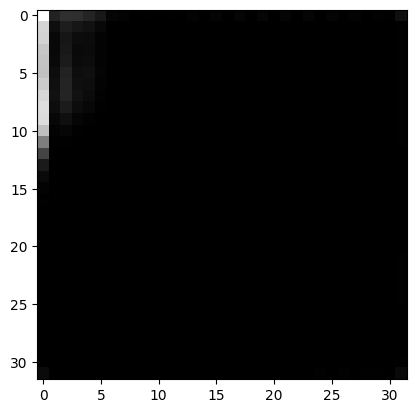

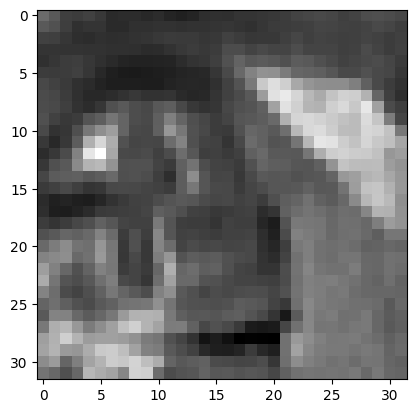

In [15]:
i = 60 
j = 60
k = 80

channel = 0

lr_patch = np.copy(subjects_lr[6][
                        i - p_size_i - e_or_o : i + p_size_i,
                        j - p_size_i - e_or_o : j + p_size_i,
                        k - p_size_i - e_or_o : k + p_size_i, :])

hr_patch = np.copy(subjects_hr[6][
                        i - p_size_o - e_or_o : i + p_size_o,
                        j - p_size_o - e_or_o : j + p_size_o,
                        k - p_size_o - e_or_o : k + p_size_o, :])

lr_mask = subjects_masks[6][
                            i - p_size_i - e_or_o : i + p_size_i,
                            j - p_size_i - e_or_o : j + p_size_i,
                            k - p_size_i - e_or_o : k + p_size_i]

lr_patch[lr_mask == 0] = 0

generated_image = generator(lr_patch[None,...], training=False)

print(discriminator(generated_image))

print(discriminator(hr_patch[None,...]))

plt.imshow(generated_image[0,:,:,3,channel],cmap='gray')
plt.figure()
plt.imshow(hr_patch[:,:,3,channel],cmap='gray')

In [16]:
# subjects_lr
# subjects_hr
# subjects_masks

result_image = np.zeros(hires_output.shape)

for (i, j, k) in tqdm(sel_indices[np.where(sel_indices[:,0]==6),1:].squeeze()):

    lr_patch = np.copy(subjects_lr[6][
                            i - p_size_i - e_or_o : i + p_size_i,
                            j - p_size_i - e_or_o : j + p_size_i,
                            k - p_size_i - e_or_o : k + p_size_i, :])

    lr_mask = subjects_masks[6][
                                i - p_size_i - e_or_o : i + p_size_i,
                                j - p_size_i - e_or_o : j + p_size_i,
                                k - p_size_i - e_or_o : k + p_size_i]

    lr_patch[lr_mask == 0] = 0

    generated_image = generator(lr_patch[None,...], training=False)

    result_image[i - p_size_o - e_or_o : i + p_size_o,
                 j - p_size_o - e_or_o : j + p_size_o,
                 k - p_size_o - e_or_o : k + p_size_o, :] = generated_image

result_image[subjects_masks[6] == 0] = 0
    

100%|███████████████████████████████████████████| 61/61 [00:00<00:00, 66.78it/s]


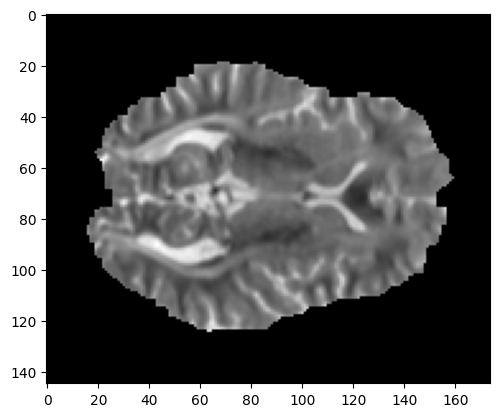

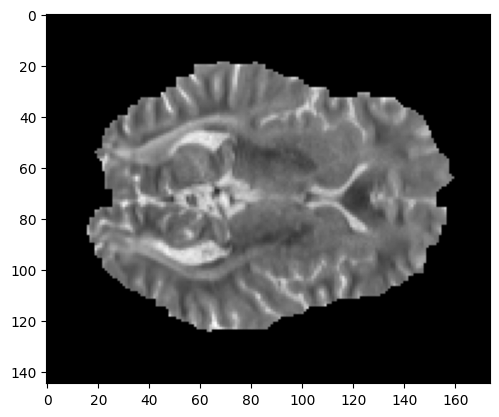

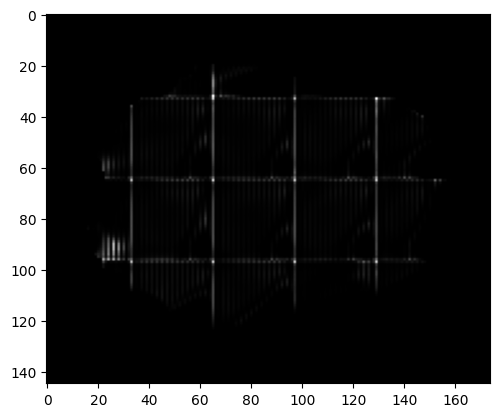

In [17]:
zdim = 60
channel = 3

# plt.imshow(subjects_masks[6][:,:,zdim], cmap='gray')
# plt.figure()
plt.imshow(subjects_lr[6][:,:,zdim,channel], cmap='gray')
plt.figure()
plt.imshow(subjects_hr[6][:,:,zdim,channel], cmap='gray')
plt.figure()
plt.imshow(result_image[:,:,zdim,channel], cmap='gray')
# plt.imshow((result_image[:,:,zdim,channel])*subjects_masks[6][:,:,zdim], cmap='gray')

0.13968277312584887 0.14297500385810397 5.369947542188669e-12


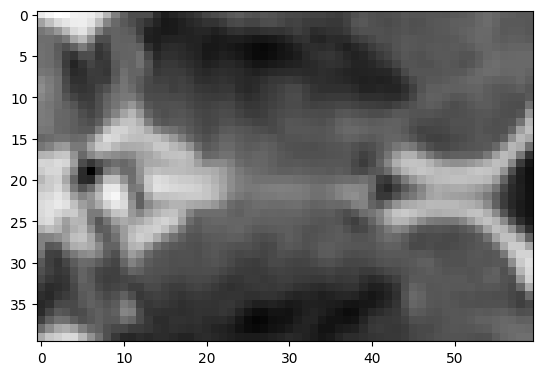

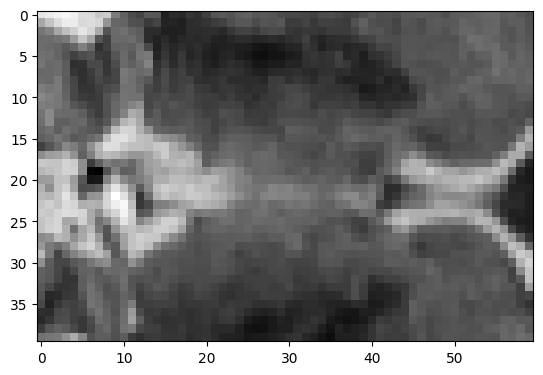

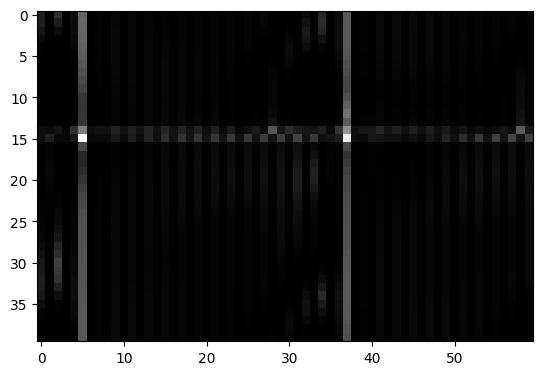

In [18]:
plt.imshow(subjects_lr[6][50:90,60:120,zdim,channel], cmap='gray')
plt.figure()
plt.imshow(subjects_hr[6][50:90,60:120,zdim,channel], cmap='gray')
plt.figure()
plt.imshow(result_image[50:90,60:120,zdim,channel], cmap='gray')

print(np.min(subjects_lr[6][40:80,60:120,zdim,channel]), np.min(subjects_hr[6][40:80,60:120,zdim,channel]), np.min(result_image[40:80,60:120,zdim,channel]))

In [19]:
# generator.save_weights('Model/gen_weights')
# discriminator.save_weights('Model/disc_weights')

In [20]:
generator.save('Model/generator{}x_dti_norm_unet'.format(2*p_size_o + e_or_o))
discriminator.save('Model/discriminator{}x_dti_norm_unet'.format(2*p_size_o + e_or_o))

INFO:tensorflow:Assets written to: Model/generator32x_dti_norm_unet/assets


INFO:tensorflow:Assets written to: Model/generator32x_dti_norm_unet/assets


INFO:tensorflow:Assets written to: Model/discriminator32x_dti_norm_unet/assets


INFO:tensorflow:Assets written to: Model/discriminator32x_dti_norm_unet/assets
